# <div style='color:white;background: #005792;text-align: center;padding: 15px 0'>Recommandations - Modélisation d'un modèle machine learning avec TfidfVectorizer et TruncatedSVD</div>

## Participants
* Samantha
* Rachelle
* Andrew

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Configuration des variables</a></div>

### Installation des librairies

In [19]:
# !pip install scikit-learn
# !pip install scikit-surprise

### Importation des librairies

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from scipy.sparse import hstack, csr_matrix, diags, vstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline


### Chargement des fichiers 

In [2]:
source_dir= '/home/dstrec/dstrec/010_data/002_merged'

file_final = f"{source_dir}/dstrec.csv"

### Chargement des jeux de données

In [3]:
dstrec = pd.read_csv(file_final)

### Configuration des fonctions

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Préparation des données</a></div>

In [4]:
dstrec.shape

(164108, 39)

In [5]:
dstrec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164108 entries, 0 to 164107
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   imdbId         164108 non-null  object 
 1   title          164108 non-null  object 
 2   averageRating  164108 non-null  float64
 3   numVotes       164108 non-null  float64
 4   director       164108 non-null  object 
 5   actor_actress  164108 non-null  object 
 6   producer       164108 non-null  object 
 7   Action         164108 non-null  int64  
 8   Adult          164108 non-null  int64  
 9   Adventure      164108 non-null  int64  
 10  Animation      164108 non-null  int64  
 11  Biography      164108 non-null  int64  
 12  Comedy         164108 non-null  int64  
 13  Crime          164108 non-null  int64  
 14  Documentary    164108 non-null  int64  
 15  Drama          164108 non-null  int64  
 16  Family         164108 non-null  int64  
 17  Fantasy        164108 non-nul

In [6]:
dstrec.head()

,imdbId,title,averageRating,numVotes,director,actor_actress,producer,Action,Adult,Adventure,...,Romance,Sci,Show,Sport,TV,Talk,Thriller,War,Western,forAdult
0,tt0000009,Miss Jerry,5.4,212.0,Alexander Black,William Courtenay/Blanche Bayliss,Alexander Black,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,tt0000574,The Story of the Kelly Gang,6.0,900.0,Charles Tait,Godfrey Cass/Bella Cola,W.A. Gibson,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,tt0001370,Rainha Depois de Morta Inês de Castro,5.2,26.0,Carlos Santos,Eduardo Brazão/Amelia Vieira,Júlio Costa,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0001790,"Les Misérables, Part 1: Jean Valjean",6.0,52.0,Albert Capellani,Jean Angelo/Maria Fromet,Pierre Decourcelle,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0001911,Nell Gwynne,3.6,26.0,Raymond Longford,Walter Bastin/Agnes Keogh,George Musgrove,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
colonnes = dstrec.columns
print("Liste des colonnes (Index):", colonnes)

Liste des colonnes (Index): Index(['imdbId', 'title', 'averageRating', 'numVotes', 'director',
       'actor_actress', 'producer', 'Action', 'Adult', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Fi', 'Film', 'Game', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Noir', 'Reality', 'Romance', 'Sci',
       'Show', 'Sport', 'TV', 'Talk', 'Thriller', 'War', 'Western',
       'forAdult'],
      dtype='object')


### Supression de la colonne des ID imdb

In [8]:
#Suppression des colonnes non utilisées dans notre modèle de recommandation
dstrec.drop('imdbId', axis=1, inplace=True)

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Création d'un modèle hybride - Final</a></div>

### Utilisation de TF-IDF et SVD

In [10]:
# Configuration de TF-IDF et SVD
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # Réduction des features TF-IDF
svd = TruncatedSVD(n_components=100)  # Réduction du nombre de composantes
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

### Création des poids des variables 

In [11]:
# Initialisation des poids
weights = {
    'title': 0,
    'producer': 1, 'actor_actress': 1,
    'director': 2,
    'averageRating': 2,  # Ceci sera traité différemment car il doit être pondéré par numVotes
    'Action': 3, 'Adult': 3, 'Adventure': 3, 'Animation': 3, 'Biography': 3,
    'Comedy': 3, 'Crime': 3, 'Documentary': 3, 'Drama': 3, 'Family': 3,
    'Fantasy': 3, 'Film': 3, 'Game': 3, 'History': 3, 'Horror': 3, 'Music': 3,
    'Musical': 3, 'Mystery': 3, 'News': 3, 'Noir': 3, 'Reality': 3, 'Romance': 3,
    'Sci': 3, 'Show': 3, 'Sport': 3, 'TV': 3, 'Talk': 3, 'Thriller': 3,
    'War': 3, 'Western': 3, 'forAdult': 3
}


### Préparation des données 

In [12]:
# Préparation des features
feature_matrices = []
for col in dstrec.columns:
    if col in weights and weights[col] > 0:
        if dstrec[col].dtype == 'object':
            tfidf_matrix = tfidf.fit_transform(dstrec[col])
            svd_matrix = lsa.fit_transform(tfidf_matrix)
            feature_matrices.append(csr_matrix(svd_matrix * weights[col]))
        else:
            # Traitement pour les colonnes numériques avec pondération
            scaled_data = dstrec[col].astype(float) * weights[col]
            feature_matrices.append(csr_matrix(scaled_data.values.reshape(-1, 1)))

# Concaténation des matrices en une seule matrice sparse
feature_matrix = hstack(feature_matrices).tocsr()

### Création du modèle hybride de recommandation

In [13]:
# Fonction pour calculer la similarité et obtenir les recommandations
def get_recommendations(title, feature_matrix, dstrec):
    # Trouver l'index du film
    idx = dstrec[dstrec['title'] == title].index[0]
    
    # Calculer la similarité entre le film choisi et tous les autres
    cosine_sim = cosine_similarity(feature_matrix[idx:idx+1], feature_matrix).flatten()
    
    # Obtenir les indices des films les plus similaires
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10, excluant le film lui-même
    
    # Récupérer les titres des films recommandés
    movie_indices = [i[0] for i in sim_scores]
    return dstrec['title'].iloc[movie_indices]

### Résultats du modèle

In [14]:
# Test de la fonction
get_recommendations("Miss Jerry", feature_matrix, dstrec)

69314                         Letniy dozhd
32710     White King, Red Queen (Russians)
103776                    Just Remembering
159391                    Çikolata Tarlasi
157881                       Premasoothram
74424                        Animusu anima
110613                              Guli +
90978                     Breaking Upwards
160436                           24 Kisses
121134                                 &Me
Name: title, dtype: object

In [15]:
get_recommendations("Toy Story", feature_matrix, dstrec)

38502                           Toy Story 2
62479                                  Cars
38620                          A Bug's Life
22962                          The Rescuers
98586                  Laid-Back Camp Movie
61076    Cardcaptor Sakura: The Sealed Card
88042                      Nussa: The Movie
61075          Cardcaptor Sakura: The Movie
98374                Trunk Train: The Movie
83505                  Kiko in the Deep Sea
Name: title, dtype: object

In [16]:
get_recommendations("Inception", feature_matrix, dstrec)

86079                           Atom Nine Adventures
104548                                         Fungi
77273                                      Star Trek
123732    Star Wars: Episode VII - The Force Awakens
97378                        Star Trek Into Darkness
67627                                       Serenity
141335                                    TED Rising
162621               Strong Hawk: My Sister's Keeper
122521                       Avengers: Age of Ultron
143592                                      Maanaadu
Name: title, dtype: object

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Interprétabilité du modèle</a></div>

### Interprétabilité relative à la similarité

In [20]:
# Calcul de similarité pour un sous-ensemble de films (recommandations de Toy Story)
def similarity_for_subset(title, feature_matrix, subset):
    idx = dstrec[dstrec['title'] == title].index[0]
    subset_idxs = dstrec[dstrec['title'].isin(subset)].index
    cosine_sim = cosine_similarity(feature_matrix[idx:idx+1], feature_matrix[subset_idxs]).flatten()
    sim_scores = {dstrec['title'].iloc[i]: cosine_sim[j] for j, i in enumerate(subset_idxs)}
    return sim_scores

# Exemple
subset = ["Toy Story 2", "Cars", "A Bug's Life", "The Rescuers"]
sim_scores = similarity_for_subset("Toy Story", feature_matrix, subset)
print(sim_scores)


{'The Rescuers': 0.9900416718187128, 'Toy Story 2': 0.9956522161229988, "A Bug's Life": 0.99158271432745, 'Cars': 0.9919317074940323}


<b>Interprétation</b><br>
Dans l'exemple que de sous-ensemble de film que nous avons choisi, nous notons que les scores de similarité sont élevés et donc que ces films risquent de nous être recommandés si l'on demande des recommandations en prenant en entrée l'un de ses films. 
Cette recommandation semble cohérente puisque les films en eux mêmes peuvent être caractérisés comme appartenant au même sous-ensemble de film.

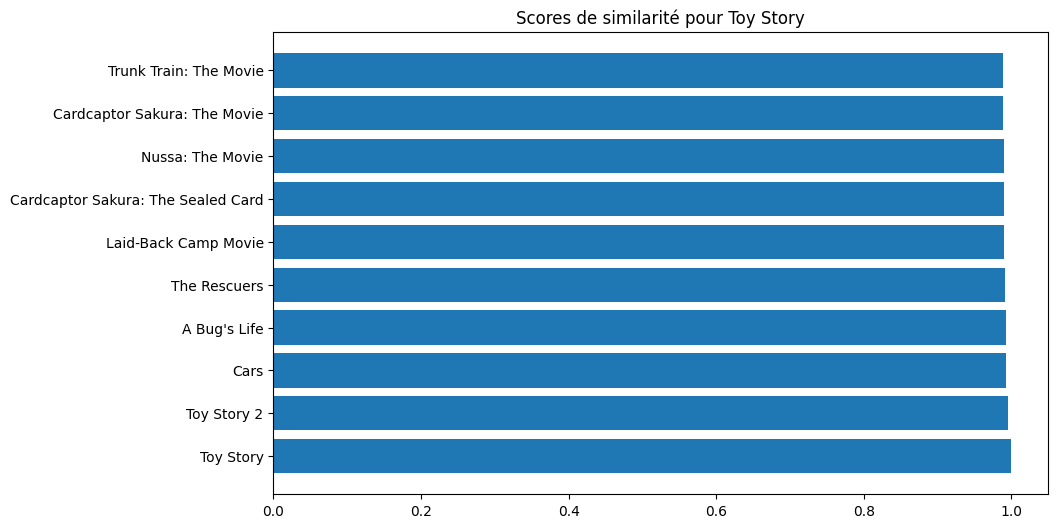

In [38]:
# Visualisation des scores de similarité :
def plot_similarity(title, feature_matrix, dstrec):
    idx = dstrec[dstrec['title'] == title].index[0]
    cosine_sim = cosine_similarity(feature_matrix[idx:idx+1], feature_matrix).flatten()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(np.arange(10), cosine_sim[np.argsort(cosine_sim)[-10:]])
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(dstrec['title'].iloc[np.argsort(cosine_sim)[-10:]])
    ax.invert_yaxis()
    ax.set_title(f"Scores de similarité pour {title}")
    plt.show()

plot_similarity("Toy Story", feature_matrix, dstrec)

<b>Interprétation</b><br>
Dans la continuité de notre précédente cellule, les films recommandés ont bien un score de similarité proche de 1 nous laissant ainsi supposé que les recommandations sont bonnes si on s'en tient à la notion de similarité.

### Interprétabilité relative aux poids attribués aux features

In [21]:
# Test de l'impact des poids sur le résultat de nos recommandations :
def test_weight_impact(title, weights, feature_matrix, dstrec, num_recommendations=10):
    feature_matrices = []
    for col in dstrec.columns:
        if col in weights:
            if dstrec[col].dtype == 'object':
                tfidf_matrix = tfidf.fit_transform(dstrec[col])
                svd_matrix = lsa.fit_transform(tfidf_matrix)
                feature_matrices.append(csr_matrix(svd_matrix * weights[col]))
            else:
                scaled_data = dstrec[col].astype(float) * weights[col]
                feature_matrices.append(csr_matrix(scaled_data.values.reshape(-1, 1)))
    
    # Concaténation des matrices en une seule matrice sparse
    feature_matrix = hstack(feature_matrices).tocsr()
    
    # Obtenir des recommandations
    return get_recommendations(title, feature_matrix, dstrec)

# Testez l'effet du changement du poids d'une caractéristique
weights_test = weights.copy()
weights_test['director'] = 5  # Augmentez significativement le poids du directeur
recommendations = test_weight_impact("Toy Story", weights_test, feature_matrix, dstrec)
print(recommendations)


38502                Toy Story 2
62479                       Cars
38620               A Bug's Life
22962               The Rescuers
156035             Over the Moon
89793                     Cars 2
45041     Gurin with the Foxtail
64057            Rugrats Go Wild
76929            Joint Adventure
71578              The Ant Bully
Name: title, dtype: object


<b>Interprétation</b><br>
Ce test a pour but d'examiner comment les poids affectent les résultats en changeant dynamiquement les poids et en observant les modifications dans les recommandations. Ceci nous permet de comprendre quelles caractéristiques ont le plus grand impact sur les résultats.
La sortie que nous obtenons après avoir ajusté les poids dans notre modèle de recommandation indique que le changement de poids a effectivement eu un impact sur les résultats. Les films recommandés montrent une variété qui pourrait refléter l'augmentation du poids attribué à la caractéristique "director". La présence de films comme "Toy Story 2", "Cars", et "A Bug's Life" montre que le système tend à recommander des films du même réalisateur ou qui partagent des styles ou des thèmes similaires. Cela peut confirmer que le poids accru du réalisateur aide à influencer les recommandations vers des films réalisés par des individus similaires ou dans des circonstances similaires.

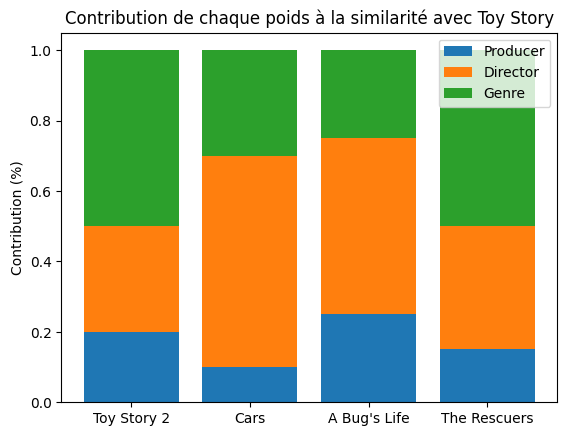

In [24]:
# Visualisation des effets des poids pour les recommandations de Toy Story :

# Simulons quelques données
films = ['Toy Story 2', 'Cars', 'A Bug\'s Life', 'The Rescuers']
categories = ['Producer', 'Director', 'Genre']
data = np.array([
    [0.2, 0.3, 0.5],
    [0.1, 0.6, 0.3],
    [0.25, 0.5, 0.25],
    [0.15, 0.35, 0.5]
])

# Normaliser les données pour que chaque barre somme à 1
data_normalized = data / data.sum(axis=1)[:, np.newaxis]

# Dessiner les barres empilées
fig, ax = plt.subplots()
for i, category in enumerate(categories):
    ax.bar(films, data_normalized[:, i], label=category, bottom=np.sum(data_normalized[:, :i], axis=1))

ax.set_ylabel('Contribution (%)')
ax.set_title('Contribution de chaque poids à la similarité avec Toy Story')
ax.legend()

plt.show()

<b>Interprétation</b><br>
Ce graphique nous permet de voir clairement l'impact des variables producer, director et genre qui ont permis de recommander ces quatre films à partir de Toy Story.
Nous visualisons clairement que pour la recommandation de Toy Story 2 et The Rescuers c'est le genre qui a eu le plus d'importance alors que pour Cars et A Bug's Life il s'agit du réalisateur. 
Cette analyse montre que votre modèle semble fonctionner de manière logique en se basant sur des caractéristiques significatives comme le genre et l'influence des réalisateurs, ce qui est un bon signe pour la cohérence et la pertinence des recommandations générées. En effet le poids que nous avons attribués à la variable genre et director est plus élevé que celui attribué à la variable producer, ce qui semble cohérent avec ce test. 

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Essais de modèles non concluants</a></div>

### 2nd test de modèle (contenu et collaboratif)

In [37]:
# # Encodage OneHot pour les colonnes catégorielles
# categorical_features = ['director', 'actor_actress', 'producer']
# onehot_encoder = OneHotEncoder()
# encoded_categorical = onehot_encoder.fit_transform(dstrec[categorical_features])

In [41]:
# # Sélection des colonnes numériques, incluant les genres
# genre_columns = dstrec.columns[7:38]  # Colonnes des genres
# numerical_data = dstrec.loc[:, genre_columns.tolist() + ['averageRating', 'numVotes']]
# numerical_sparse = csr_matrix(numerical_data.values)  # Conversion en matrice sparse


In [42]:
# # Création des poids pour chaque colonne numérique
# weights = np.concatenate(([3]*31, [2, 2]))  # 31 genres à poids 3, averageRating et numVotes à poids 2
# weight_matrix = diags(weights)  # Créer la matrice de poids

In [43]:
# # Appliquer les poids
# weighted_features = weight_matrix.dot(numerical_sparse.T).T 

In [44]:
# # Concaténation des matrices sparse numériques et catégorielles
# all_features_sparse = hstack([weighted_features, encoded_categorical])

In [10]:
# # Calcul de la similarité cosinus
# cosine_sim = cosine_similarity(all_features_sparse, dense_output=False)

In [ ]:
# # Fonction pour obtenir des recommandations basées sur la similarité cosinus
# def get_recommendations(movie_index, cosine_sim_matrix=cosine_sim):
#     sim_scores = list(enumerate(cosine_sim_matrix.getrow(movie_index).toarray().flatten()))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:11]  # Top 10 recommendations
#     movie_indices = [i[0] for i in sim_scores]
#     return dstrec['title'].iloc[movie_indices]

In [ ]:
# # Utilisation du filtrage collaboratif pour comparaison
# reader = Reader(rating_scale=(1, 10))
# data = Dataset.load_from_df(dstrec[['title', 'averageRating', 'numVotes']], reader)
# trainset, testset = train_test_split(data, test_size=0.2)
# algo = SVD()
# algo.fit(trainset)
# predictions = algo.test(testset)
# print('RMSE:', accuracy.rmse(predictions))

In [ ]:
# # Exemple de recommandation pour le premier film
# recommended_movies = get_recommendations(0)
# print(recommended_movies)

In [25]:
# # Fonction pour appliquer les poids aux caractéristiques numériques
# def apply_weights(data):
#     # Poids pour le titre
#     title_weight = [0]  # title
    
#     # Poids pour les genres (31 genres)
#     genre_weights = [3] * 31
    
#     # Poids pour les caractéristiques numériques
#     ratings_votes_weights = [2, 2]  # averageRating, numVotes
    
#     # Poids pour les colonnes catégorielles encodées (director, actor_actress, producer)
#     director_weights = [2] * encoded_categorical.shape[1]  # Supposant une colonne par catégorie après OneHot
#     actor_producer_weights = [1] * encoded_categorical.shape[1]
    
#     # Concaténation de tous les poids dans l'ordre correct des colonnes
#     weights = np.concatenate([title_weight, genre_weights, ratings_votes_weights, director_weights, actor_producer_weights])
#     return data * weights

### 1er test de modele (contenu et collaboratif)

In [9]:
# # Système basé sur le contenu
# tfidf = TfidfVectorizer(stop_words='english')
# dstrec['title'] = dstrec['title'].fillna('')
# tfidf_matrix = tfidf.fit_transform(dstrec['title'])
# cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [10]:
# # Recommander des films similaires à un film donné
# def get_recommendations(title, cosine_sim=cosine_sim):
#     idx = dstrec[dstrec['title'] == title].index[0]
#     sim_scores = list(enumerate(cosine_sim[idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:11]
#     movie_indices = [i[0] for i in sim_scores]
#     return dstrec['title'].iloc[movie_indices]


In [11]:
# # Filtrage collaboratif
# reader = Reader(rating_scale=(1, 10))
# data = Dataset.load_from_df(dstrec[['imdbId', 'averageRating', 'numVotes']], reader)
# trainset, testset = train_test_split(data, test_size=0.2)
# algo = SVD()
# algo.fit(trainset)
# predictions = algo.test(testset)
# accuracy.rmse(predictions)


RMSE: 43663.7153


43663.71526392977

In [12]:
# Exemple de recommandation hybride
# def hybrid_recommendations(user_id, title, top_n=10):
#      # Recommandations basées sur le contenu
#     content_recommendations = get_recommendations(title).tolist()
    
#     # Recommandations par filtrage collaboratif
#     # Supposons que nous voulons les top N films prédits par SVD pour l'utilisateur
#     user_movies = dstrec[dstrec['imdbId'].isin(dstrec['imdbId'].sample(frac=0.01))]
#     user_movies['rating'] = user_movies['averageRating'] * user_movies['numVotes']
    
#     # Sélection des top N films prédits par SVD pour l'utilisateur
#     user_ratings = []
#     for index, row in user_movies.iterrows():
#         rating = algo.predict(user_id, row['imdbId']).est
#         user_ratings.append((row['title'], rating))
    
#     # Tri des prédictions par note (descendante) et sélection des top N
#     user_ratings.sort(key=lambda x: x[1], reverse=True)
#     collaborative_recommendations = [movie[0] for movie in user_ratings[:top_n]]
    
#     # Recommandations hybrides : combiner basées sur le contenu et filtrage collaboratif
#     hybrid_recommendations = list(set(content_recommendations) | set(collaborative_recommendations))
    
#     return hybrid_recommendations[:top_n]


In [15]:
# # Test de la recommandation hybride
# hybrid_recommendations(user_id=1, title='Inception')


/var/folders/0z/pqtk92lj6f7dv8qdw5t5vwqr0000gn/T/ipykernel_1798/2313173106.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_movies['rating'] = user_movies['averageRating'] * user_movies['numVotes']


['The Independence of Romania',
 'The Circular Staircase',
 'A Trip to Mars',
 'The Flying Horseman',
 'Anny - Story of a Prostitute',
 'Nell Gwynne',
 "Wolfheart's Revenge",
 'Les Misérables, Part 1: Jean Valjean',
 'The Story of the Kelly Gang',
 'Her Sacrifice']

In [14]:
# hybrid_recommendations(user_id=1, title='Miss Jerry')


/var/folders/0z/pqtk92lj6f7dv8qdw5t5vwqr0000gn/T/ipykernel_1798/2313173106.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_movies['rating'] = user_movies['averageRating'] * user_movies['numVotes']


['Miss X',
 'Romance of the Wasteland',
 'Miss',
 'Miss O',
 'The Darkening Trail',
 'Soul of the Beast',
 'Miss You Already',
 'Ship of Souls',
 'I Miss U',
 'Miss Call']